# Задание

Даны координаты скважин входа в пласт и забоя горизонтальной скважины, а так же вскрытая нефтенасыщенная мощность, определить дренируемый объем пласта приходящийся на скважину

# Решение

## Inputs

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Vars

## Functions

In [6]:
def rotate(A,B,C):
  return (B[0]-A[0])*(C[1]-B[1])-(B[1]-A[1])*(C[0]-B[0])

def grahamscan(A):
    n = len(A) # число точек
    P = list(range(n)) # список номеров точек

    for i in range(1, n):
        if A[P[i]][0]<A[P[0]][0]: # если P[i]-ая точка лежит левее P[0]-ой точки
            P[i], P[0] = P[0], P[i] # меняем местами номера этих точек 
    for i in range(2, n): # сортировка вставкой
        j = i
        while j>1 and (rotate(A[P[0]],A[P[j-1]],A[P[j]])<0): 
            P[j], P[j-1] = P[j-1], P[j]
            j -= 1

    S = [P[0],P[1]] # создаем стек

    for i in range(2, n):
        while rotate(A[S[-2]],A[S[-1]],A[P[i]])<0:
            del S[-1] # pop(S)
            S.append(P[i]) # push(S,P[i])

    return S

def jarvismarch(A):
    n = len(A)
    P = list(range(n))

    # start point
    for i in range(1,n):
        if A[P[i]][0]<A[P[0]][0]: 
            P[i], P[0] = P[0], P[i]  

    H = [P[0]]
    del P[0]
    P.append(H[0])

    while True:
        right = 0
        for i in range(1,len(P)):
            if rotate(A[H[-1]],A[P[right]],A[P[i]])<0:
                right = i
        if P[right]==H[0]: 
            break
        else:
            H.append(P[right])
            del P[right]
    return H    

In [7]:
def method_Gaussa(A):
    S = 0

    for i, point_X in enumerate(A[0][:-1]):
        S += point_X * A[1][i+1]

    for i, point_X in enumerate(A[1][:-1]):
        S -= point_X * A[0][i+1]

    S /= 2

    return S

## Main

### Читаем датасет

In [10]:
df = pd.read_csv('./data2hard.csv')
df

,WELL_ID,X_TOP,Y_TOP,X_BHP,Y_BHP,h
0,110000204,451633,7595651,451633,7595651,11
1,110001100,451521,7600570,450897,7600603,9
2,110001200,452201,7600490,452910,7601194,11
3,110001300,451492,7599970,450897,7599984,10
4,110001400,452552,7599990,453259,7600674,14
...,...,...,...,...,...,...
588,110805800,439771,7594408,439907,7593380,12
589,110806200,440408,7595838,440274,7596674,14
590,110806400,439633,7594308,439752,7593334,14
591,110807000,439238,7594248,439301,7593185,12


### Первиная информация

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   WELL_ID  593 non-null    int64
 1   X_TOP    593 non-null    int64
 2   Y_TOP    593 non-null    int64
 3   X_BHP    593 non-null    int64
 4   Y_BHP    593 non-null    int64
 5   h        593 non-null    int64
dtypes: int64(6)
memory usage: 27.9 KB


In [12]:
df.describe()

,WELL_ID,X_TOP,Y_TOP,X_BHP,Y_BHP,h
count,5.930000e+02,593.000000,5.930000e+02,593.000000,5.930000e+02,593.000000
mean,1.101709e+08,452729.273187,7.600450e+06,452741.868465,7.600455e+06,10.885329
std,1.883939e+05,4828.073423,4.344895e+03,4952.755651,4.435065e+03,1.939195
min,1.100002e+08,439238.000000,7.593009e+06,439301.000000,7.592194e+06,8.000000
25%,1.100362e+08,449231.000000,7.597027e+06,449046.000000,7.597162e+06,9.000000
50%,1.100694e+08,452202.000000,7.599523e+06,452410.000000,7.599833e+06,11.000000
75%,1.103035e+08,455689.000000,7.602877e+06,455968.000000,7.602973e+06,12.000000
max,1.108076e+08,464430.000000,7.611944e+06,464732.000000,7.613004e+06,14.000000


In [13]:
for col in df.columns:
    print(
        col, len(df[col].unique())
    )

WELL_ID 592
X_TOP 581
Y_TOP 578
X_BHP 578
Y_BHP 579
h 7


In [14]:
for h in df.h.unique():
    print(h, len(df[df.h == h].values))

11 90
9 92
10 93
14 71
12 88
13 77
8 82


### Теоритическое решение

Объём - произведение высоты/толщины на площадь фигуры.

У нас есть координаты скважин. И есть нефтенассыщенная мощность - толщина нефтенассыщеного слоя. Получается, что нам необходимо разбить датасет на нефтенассыщенные можности. У нас их 7. После чего, исходя из координат скважин, посчитать площадь, которую покрывают скважины и умножить F на h, так как формула, которую я нашёл выглядит следующим образом: V = Fh.

### Проверка теории

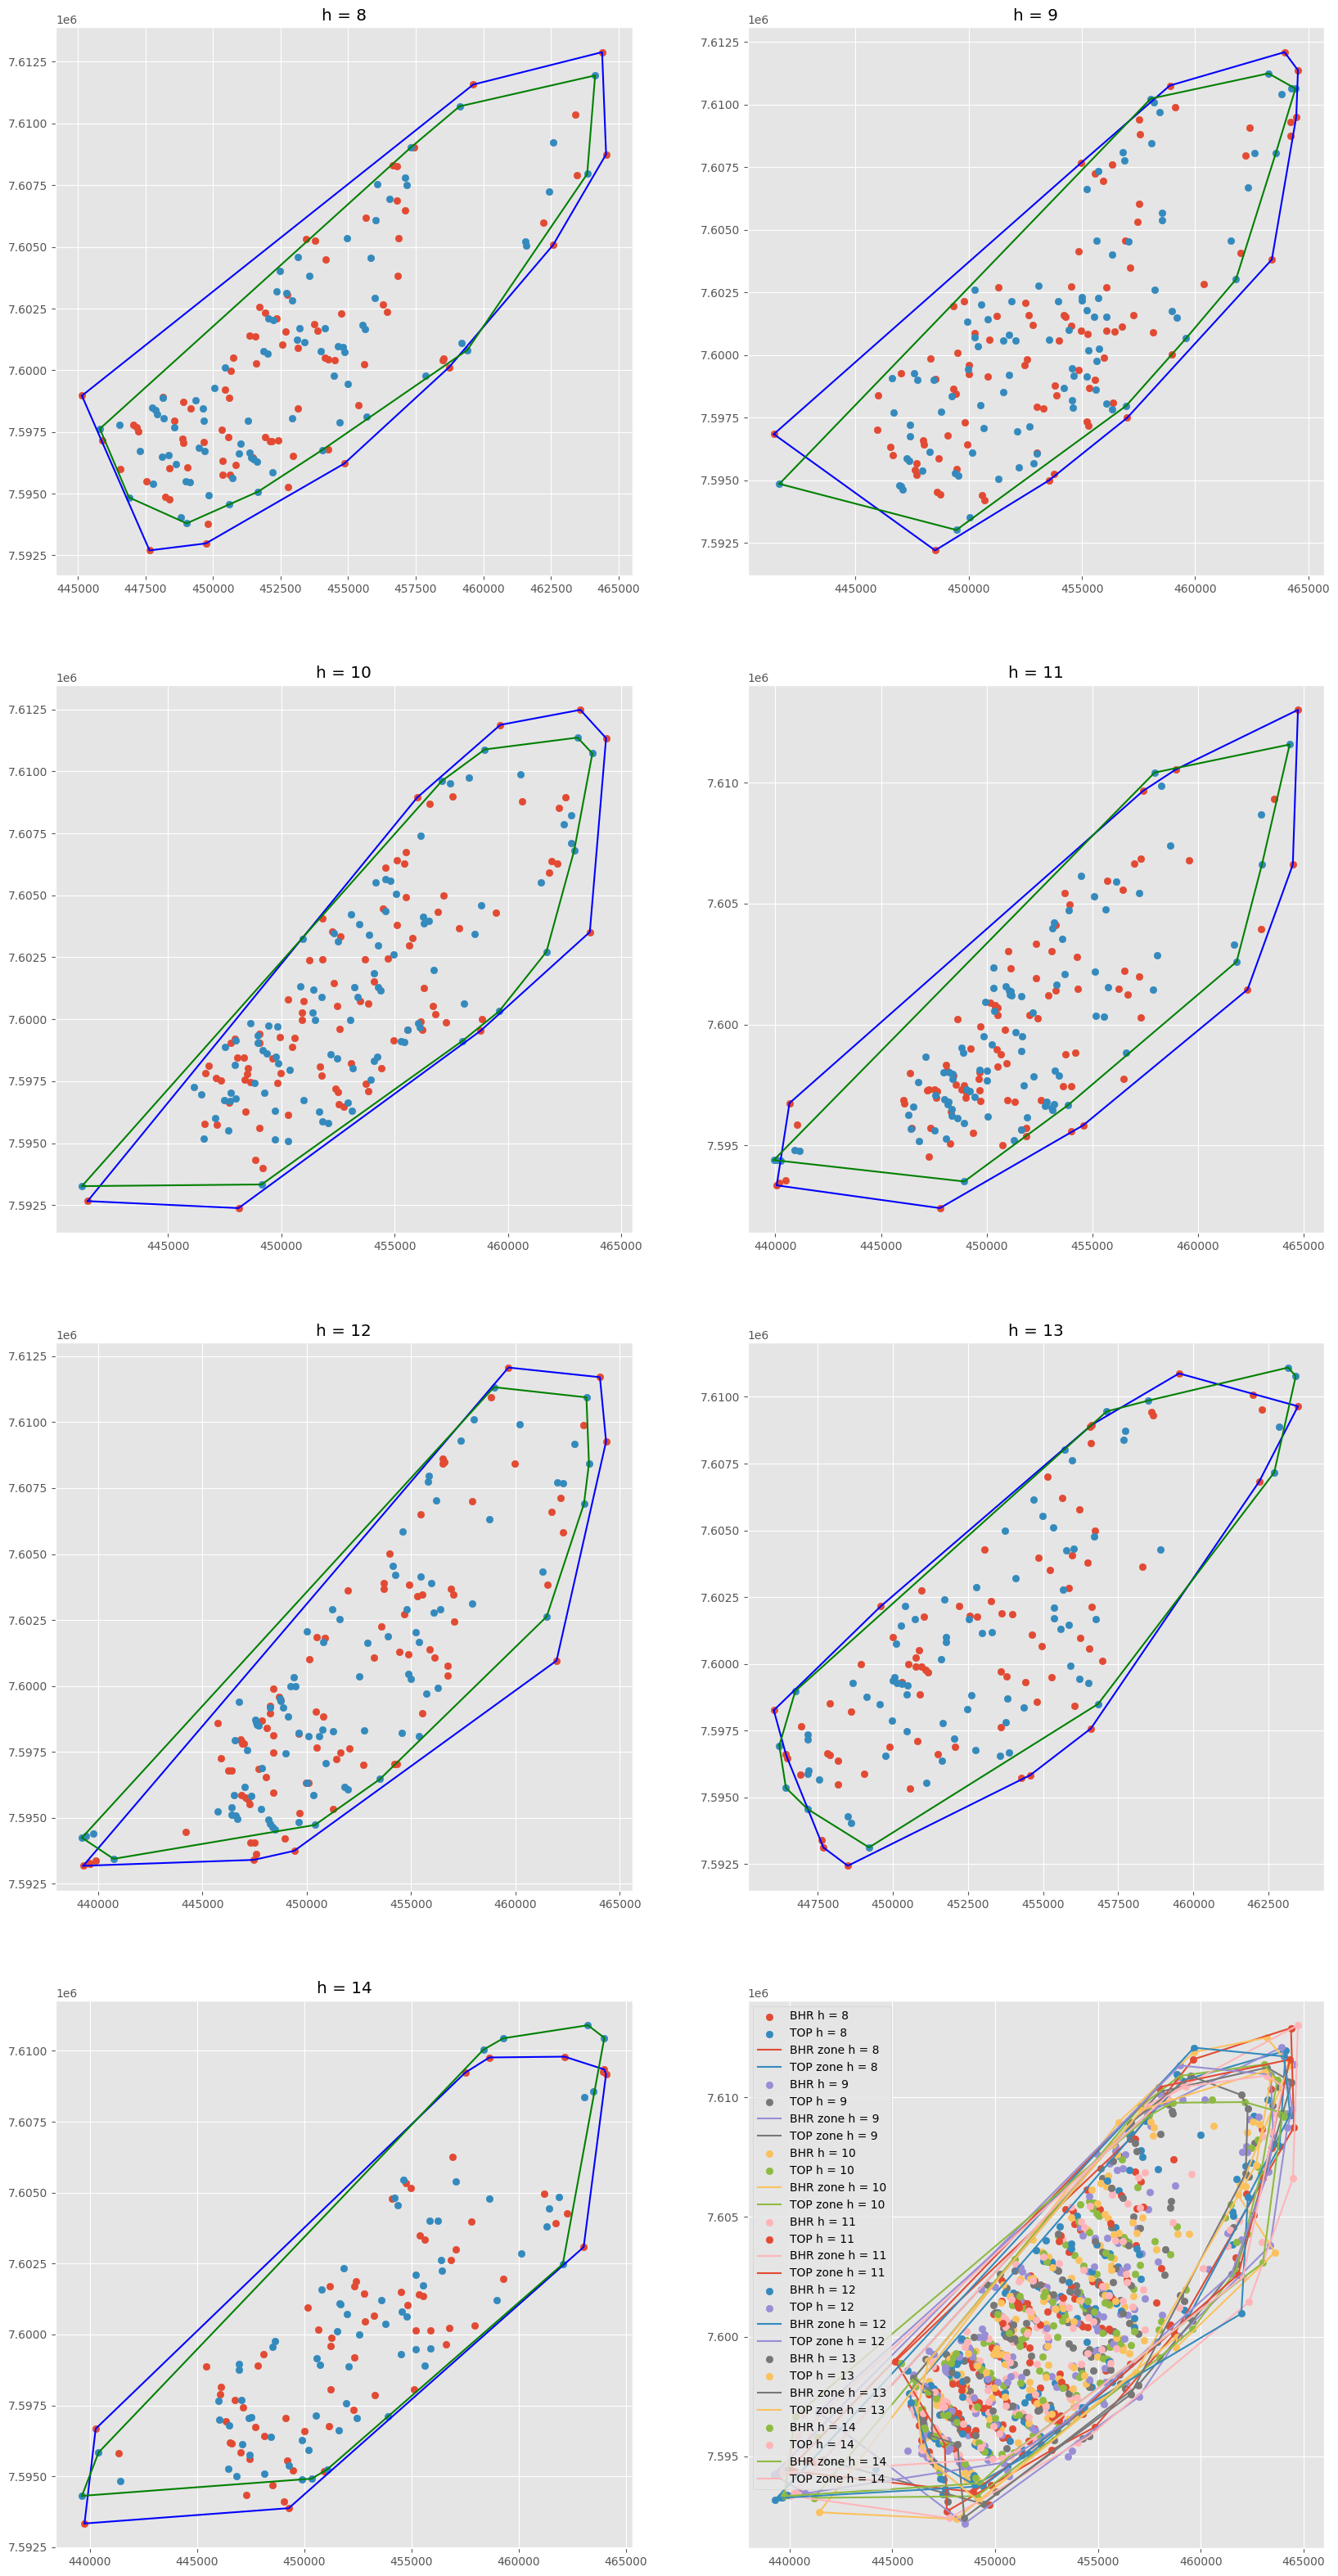

In [30]:
fig, axs = plt.subplots(4, 2, figsize = (20, 40))
row = -1

for i, h in enumerate(sorted(df.h.unique())):
    col = i % 2
    if col == 0:
        row += 1

    axs[row, col].scatter(
        df[df.h == h].X_BHP,
        df[df.h == h].Y_BHP,
        label = 'h = '+str(h),
    )

    axs[row, col].scatter(
        df[df.h == h].X_TOP,
        df[df.h == h].Y_TOP,
        label = 'h = '+str(h),
    )

    axs[row, col].set_title(
        'h = '+str(h)
    )
    
    border_points = jarvismarch(
        df[df.h == h][['X_BHP', 'Y_BHP']].reset_index().drop(columns = ['index']).values
    )

    border_points.append(border_points[0])

    axs[row, col].plot(
        df[df.h == h].X_BHP.iloc[border_points],
        df[df.h == h].Y_BHP.iloc[border_points],
        label = 'h = '+str(h),
        color = 'blue'
    )

    border_points = jarvismarch(
        df[df.h == h][['X_TOP', 'Y_TOP']].reset_index().drop(columns = ['index']).values
    )

    border_points.append(border_points[0])

    axs[row, col].plot(
        df[df.h == h].X_TOP.iloc[border_points],
        df[df.h == h].Y_TOP.iloc[border_points],
        label = 'h = '+str(h),
        color = 'green'
    )

    # ===== Last cell =====
    axs[-1, -1].scatter(
        df[df.h == h].X_BHP,
        df[df.h == h].Y_BHP,
        label = 'BHR h = '+str(h)
    )
    axs[-1, -1].scatter(
        df[df.h == h].X_TOP,
        df[df.h == h].Y_TOP,
        label = 'TOP h = '+str(h)
    )

    axs[-1, -1].plot(
        df[df.h == h].X_BHP.iloc[border_points],
        df[df.h == h].Y_BHP.iloc[border_points],
        label = 'BHR zone h = '+str(h),
    )
    axs[-1, -1].plot(
        df[df.h == h].X_TOP.iloc[border_points],
        df[df.h == h].Y_TOP.iloc[border_points],
        label = 'TOP zone h = '+str(h),
    )

axs[-1, -1].legend(
    numpoints=1
)

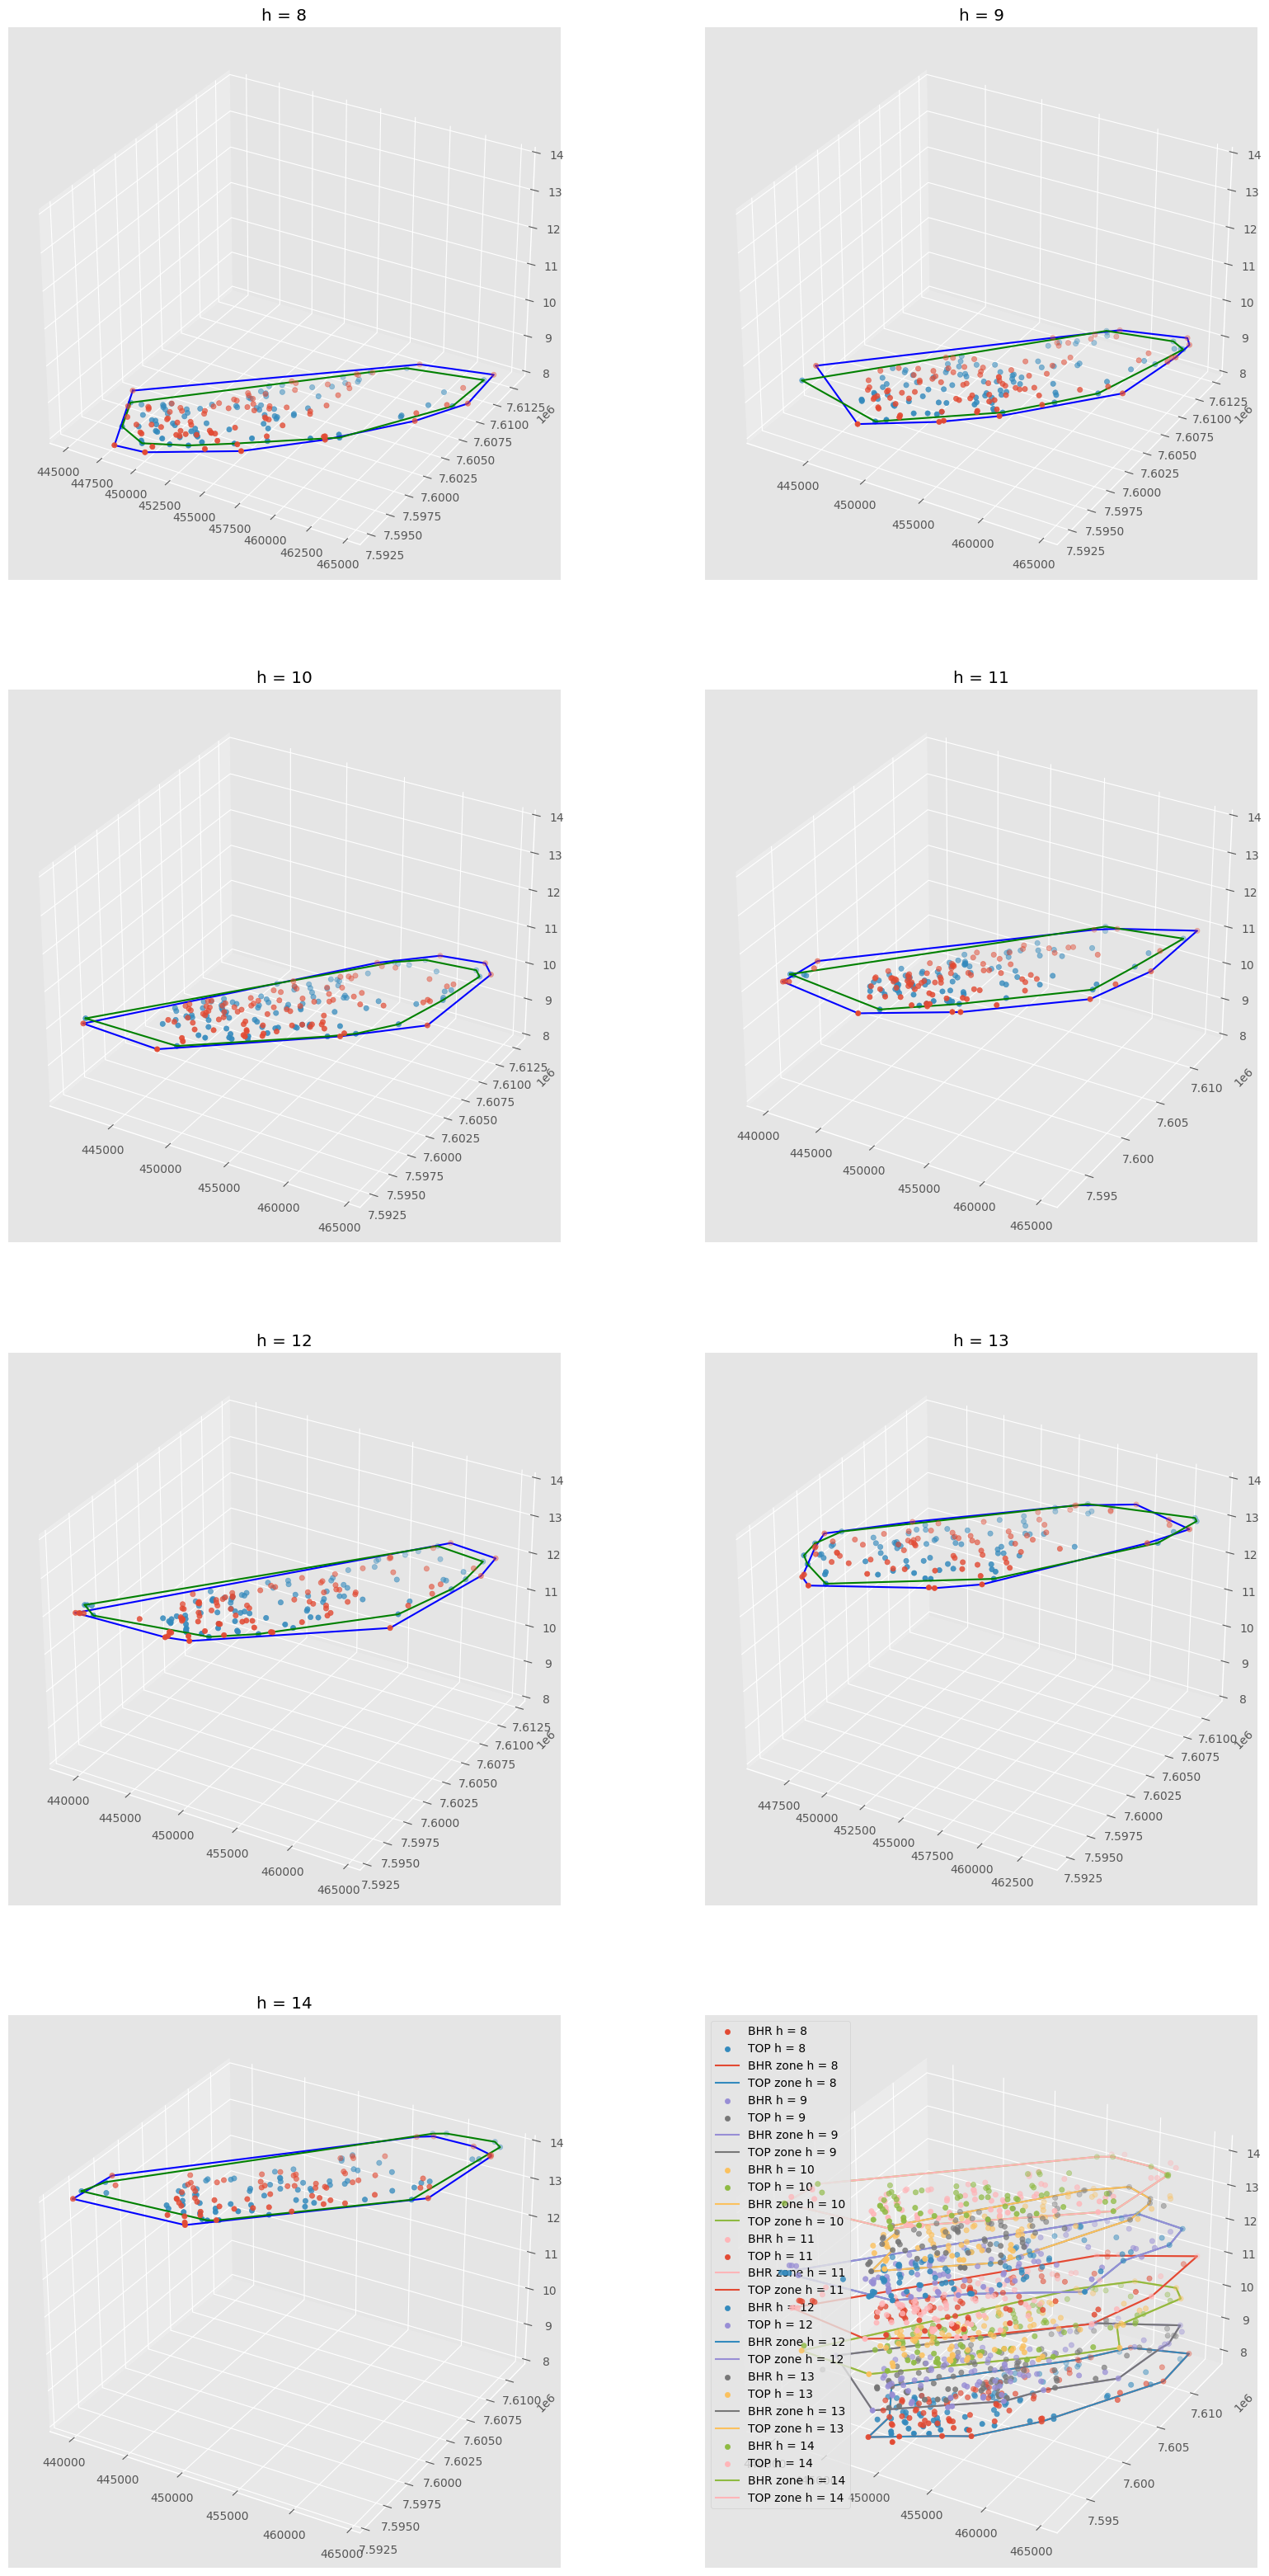

In [29]:
fig, axs = plt.subplots(4, 2, figsize = (20, 40),subplot_kw=dict(projection='3d'))
row = -1

for i, h in enumerate(sorted(df.h.unique())):
    col = i % 2
    if col == 0:
        row += 1

    axs[row, col].scatter(
        df[df.h == h].X_BHP,
        df[df.h == h].Y_BHP,
        df[df.h == h].h,
        label = 'h = '+str(h),
    )

    axs[row, col].scatter(
        df[df.h == h].X_TOP,
        df[df.h == h].Y_TOP,
        df[df.h == h].h,
        label = 'h = '+str(h),
    )

    axs[row, col].set_zlim3d(
        df.h.min(),
        df.h.max(),
    )

    axs[row, col].set_title(
        'h = '+str(h)
    )
    
    border_points = jarvismarch(
        df[df.h == h][['X_BHP', 'Y_BHP']].reset_index().drop(columns = ['index']).values
    )

    border_points.append(border_points[0])

    axs[row, col].plot(
        df[df.h == h].X_BHP.iloc[border_points],
        df[df.h == h].Y_BHP.iloc[border_points],
        df[df.h == h].h.iloc[border_points],
        label = 'h = '+str(h),
        color = 'blue'
    )

    border_points = jarvismarch(
        df[df.h == h][['X_TOP', 'Y_TOP']].reset_index().drop(columns = ['index']).values
    )

    border_points.append(border_points[0])

    axs[row, col].plot(
        df[df.h == h].X_TOP.iloc[border_points],
        df[df.h == h].Y_TOP.iloc[border_points],
        df[df.h == h].h.iloc[border_points],
        label = 'h = '+str(h),
        color = 'green'
    )

    # ===== Last cell =====
    axs[-1, -1].scatter(
        df[df.h == h].X_BHP,
        df[df.h == h].Y_BHP,
        df[df.h == h].h,
        label = 'BHR h = '+str(h)
    )
    axs[-1, -1].scatter(
        df[df.h == h].X_TOP,
        df[df.h == h].Y_TOP,
        df[df.h == h].h,
        label = 'TOP h = '+str(h)
    )

    axs[-1, -1].plot(
        df[df.h == h].X_TOP.iloc[border_points],
        df[df.h == h].Y_TOP.iloc[border_points],
        df[df.h == h].h.iloc[border_points],
        label = 'BHR zone h = '+str(h),
    )
    axs[-1, -1].plot(
        df[df.h == h].X_BHP.iloc[border_points],
        df[df.h == h].Y_BHP.iloc[border_points],
        df[df.h == h].h.iloc[border_points],
        label = 'TOP zone h = '+str(h),
    )

axs[-1, -1].legend(
    numpoints=1
)

### Рассчёт объёма

In [17]:
df['V'] = 0

for i, h in enumerate(sorted(df.h.unique())):
    border_points = jarvismarch(
        df[df.h == h][['X_BHP', 'Y_BHP']].reset_index().drop(columns = ['index']).values
    )

    border_points.append(border_points[0])

    x_list = df[df.h == h].X_BHP.iloc[border_points].values
    y_list = df[df.h == h].Y_BHP.iloc[border_points].values
    h_list = df[df.h == h].h

    S = method_Gaussa(
        [x_list, y_list]
    )
    
    df['V'][df.h == h] = S * h_list


### Итог:

In [18]:
df

,WELL_ID,X_TOP,Y_TOP,X_BHP,Y_BHP,h,V
0,110000204,451633,7595651,451633,7595651,11,2.515210e+09
1,110001100,451521,7600570,450897,7600603,9,1.832159e+09
2,110001200,452201,7600490,452910,7601194,11,2.515210e+09
3,110001300,451492,7599970,450897,7599984,10,1.868680e+09
4,110001400,452552,7599990,453259,7600674,14,2.620897e+09
...,...,...,...,...,...,...,...
588,110805800,439771,7594408,439907,7593380,12,2.363950e+09
589,110806200,440408,7595838,440274,7596674,14,2.620897e+09
590,110806400,439633,7594308,439752,7593334,14,2.620897e+09
591,110807000,439238,7594248,439301,7593185,12,2.363950e+09


In [19]:
df.to_csv('./result.csv', sep=',')

По-сути, мы нашли геометрический объём, а не дринируемый объём, если верить тому, что я успел выяснить, так как нам не хватает некоторых данных, таких как: пористость, остаточная водонасыщенность и остаточная нефтенасыщенность.

А общая формула должна выглядеть примерно так: Vp.dr. = x * y * z * Vp * (1-Swc-Sor)